# Semi-Supervised Learning

**Goal:** Is to develop a Pseudo-labeling approach to label tweets as hate or non-hate which is a Semi-Supervised Learning classification task.

In [17]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import os
import json
import datetime
import contractions
import pickle
import mysql.connector
from mysql.connector import Error
from imblearn.over_sampling import SMOTE
from sklearn.semi_supervised import LabelPropagation
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
import joblib
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score,f1_score
from sklearn.metrics import auc, average_precision_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from string import punctuation
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
plt.rcParams['figure.figsize'] = (18, 5)
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import sys
# Path to the module (ModelInference) and config
sys.path.append('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src')
from pipeline.modelinference import ModelInference
from config import config

In [2]:
class ToPandasDF():
    def __init__(self, password, host, database, user):

        self.password = password
        self.host = host
        self.database = database
        self.user = user
        
    
    def MySQLconnect(self, query):
        
        try:
            connection = mysql.connector.connect(host=self.host, 
                                                 database=self.database, 
                                                 password=self.password,
                                                 user=self.user)

            if connection.is_connected():

                print("Successfully connected to the database\n")

                cursor = connection.cursor()
                query = query
                cursor.execute(query)

                data = cursor.fetchall()

                df = pd.DataFrame(data, columns = ['id', 'date', 'tweet'])
        except Error as e:
            print(e)
            
        cursor.close()
        connection.close()
        
        return df
    
    def check_if_valid_data(self, data):
        
        # Create a timestamp of the date(Day, Month & Year)
        data['timestamp'] = data['date'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
        
        if data.empty:
            print("No tweets downloaded. Finishing execution")
            
        if data['id'].unique().all():
            pass
        else:
            print(f"Primary Key check is violated, Number of duplicate values: {data.duplicated().sum()}")
            
        if data.isnull().values.any():
            print(f"\nNull values detected, Number of null: \n{data.isnull().sum()}")
        
        yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
        yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)
        timestamps = data['timestamp'].tolist()
        for timestamp in timestamps:
            if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
                print("Atleast one of the returned tweet does not come from within the last 24 hours")
        
    def basic_processing(self, data):
        data = data.drop(['date', 'timestamp'], axis=1)
        print(f'\nNumber of duplicate entry of unlabelled data: {data.tweet.duplicated().sum()}')
        # Remove duplicates
        data = data[~data.tweet.duplicated()]
        print(f'Duplicate entry removed: {data.tweet.duplicated().sum()}')
        # We will remove the usernames and RT(retweet) in the tweet column
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
        return data

    def load_train_data(self):
        data = pd.read_csv(os.path.join(config.DATAPATH, 'train.csv'))
        # Remove all records with no label
        data = data[data.label != '']
        # data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
        return data

if __name__ == '__main__':
    
    t = ToPandasDF(config.PASSWORD, config.HOST, config.DATABASE, config.USER)
    stored_data = t.MySQLconnect("SELECT id, created_at, tweet FROM `twitterdb`.`twitter_table`;")
    t.check_if_valid_data(stored_data)
    unlabelled_data = t.basic_processing(stored_data)
    labelled_data = t.load_train_data()

Successfully connected to the database

Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the returned tweet does not come from within the last 24 hours
Atleast one of the retur

In [3]:
print(unlabelled_data.shape)
unlabelled_data.info()
unlabelled_data.head(10)

(3112, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3112 entries, 0 to 4022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3112 non-null   object
 1   tweet   3112 non-null   object
dtypes: object(2)
memory usage: 72.9+ KB


,id,tweet
0,1547971096388915211,Truth and Reconciliation Week - sign up VSB ed...
1,1547973807876345856,Uh oh she’s writing songs #inthefeels 🔪
2,1548039239316541449,#Killing white #supremacists by Bill O'Really....
3,1548287847995609092,hiya. cats are feeling fuming and accomplished...
4,1548297674062868480,If home ownership requires generational wealth...
5,1548327299304783875,RT @RobertR41182121: THIS IS SATANIC #ZIONAZI ...
6,1548582052240539648,@Inspiredlawyer #BabyFactories: sick ultimate ...
7,1548640420418273282,#Platform class kotlin.Unit #requires explicit...
8,1548681295189901317,The Let Them Eat Cake Club #Supremacists #Liar...
10,1549225465658982401,Kinda sad my bachelorette party is over 🥺#miss...


In [4]:
# Initialize the TfidfVectorizer, Lemmatizer and stopwords
# tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)tfVectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, max_features=800, ngram_range=(1, 1), use_idf=True)
tfVectorizer = TfidfVectorizer(min_df=5, max_df=0.75, max_features=1000, ngram_range=(1, 2))
lemmatizer = WordNetLemmatizer()
stopwords = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_nltk_stopwords.json", "r")))
stopwords_json = set(json.load(open("/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/stopWords/custome_json_stopwords.json", "r")))
stopwords_punctuation = set.union(stopwords, stopwords_json, punctuation)

print(labelled_data.shape)
labelled_data.info()
labelled_data.head(10)

(31962, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 998.8+ KB


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


# Target Exploration (label)

In [5]:
labelled_data.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

**The dataset is imbalanced based on hate speech**

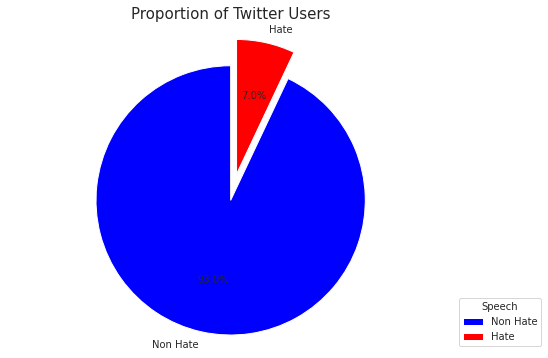

In [6]:
size=labelled_data.label.value_counts()
labels='Non Hate', 'Hate'
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(size, explode=(0, 0.2), labels=labels, autopct='%1.1f%%', startangle=90, colors=['blue', 'red'])
ax.axis('equal')
plt.title('Proportion of Twitter Users', size=15)
ax.legend(labels, bbox_to_anchor=(1, 0), loc='lower left', title='Speech')
plt.show()

It is given that 7.0% of twitter users might Hate. So the baseline model could be to predict that 7.0% of the users will Hate. Given 7.0% is a small number, we need to ensure that the chosen model does predict with great accuracy this 7.0% as it is of interest to the company to identify these users as opposed to accurately predicting the users that are non haters.

In [7]:
def basic_prep(data):
    data['mention_count'] = data.tweet.apply(lambda x: len(re.findall(r"@[\w\-]+", x)))
    data['tweet'] = data.tweet.replace(regex=re.compile(r"@([A-Za-z0-9_]+)"), value='')
    data['tweet'] = data.tweet.replace(regex=re.compile(r"RT([\s:]+)"), value='')
    return data

def preprocess_text(text):
    
    """Function to clean text from irrelevant words and symbols"""
    
    if type(text) == float:
        print('Entry not valid')
        return ""
    sentence = []
    
    # Tokenize and lowercase all alphabet
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(str(text))]
    
    # Part of speech
    tags = pos_tag(tokens)
    
    for (token, tag) in tags:
        # Remove all irrelevant symbols from token
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        
        # Grab the positions of the nouns(NN), verbs(VB), adverb(RB), and adjective(JJ)
        if tag.startswith('NN'):
            position = 'n'
        elif tag.startswith('VB'):
            position = 'v'
        elif tag.startswith('RB'):
            position = 'r'
        else:
            position = 'a'

        lemmatized_word = lemmatizer.lemmatize(token, position)
        if lemmatized_word not in stopwords_punctuation:
            sentence.append(lemmatized_word)
    final_sent = ' '.join(sentence)
    final_sent = final_sent.replace("n't", 'not').replace("nt", "not")
    return final_sent

data_cleaned = labelled_data.copy()
data_cleaned = basic_prep(data_cleaned)
data_cleaned['cleaned_text'] = data_cleaned.tweet.apply(preprocess_text)
print(f'The longest for labelled tweet is: {max(data_cleaned.cleaned_text.str.len())}')
print(f'The shortest for labelled tweet is: {min(data_cleaned.cleaned_text.str.len())}')

unlabelled_cleaned = unlabelled_data.copy()
unlabelled_cleaned = basic_prep(unlabelled_cleaned)
unlabelled_cleaned['cleaned_text'] = unlabelled_cleaned.tweet.apply(preprocess_text)
print(f'The longest for unlabelled tweet is: {max(unlabelled_cleaned.cleaned_text.str.len())}')
print(f'The shortest for unlabelled tweet is: {min(unlabelled_cleaned.cleaned_text.str.len())}')


The longest for labelled tweet is: 196
The shortest for labelled tweet is: 0
The longest for unlabelled tweet is: 297
The shortest for unlabelled tweet is: 0


# Visualize Word frequency

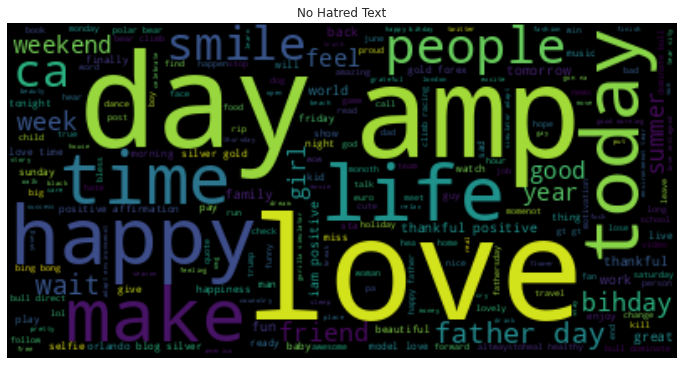

In [8]:
# Let's split the dataset into non hate(0) and hate(1) so as to visualize the frequency of the words
no_hate = data_cleaned[data_cleaned['label']==0]
hate = data_cleaned[data_cleaned['label']==1]

wordcloud = WordCloud(background_color='black').generate(' '.join(no_hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('No Hatred Text')
plt.axis('off')
plt.show()

**Above, we can see that those are `non-hate` related words**

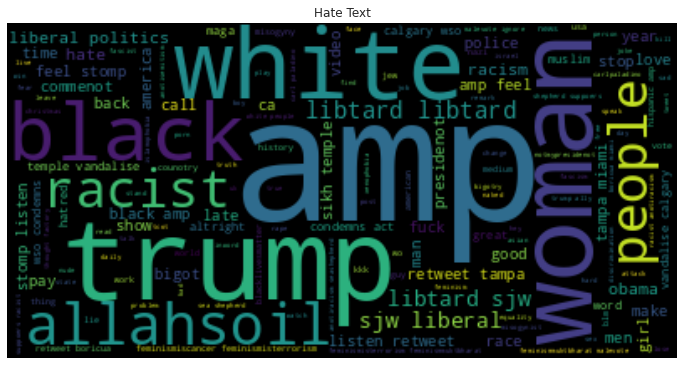

In [9]:
wordcloud = WordCloud(background_color='black').generate(' '.join(hate.cleaned_text))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Hate Text')
plt.axis('off')
plt.show()

In [10]:
# We will encode text data using TF-IDF

def transform(data_cleaned, unlabelled_cleaned):
    tfVectorizer.fit(data_cleaned.cleaned_text)
    train_tfidf_feat = tfVectorizer.transform(data_cleaned.cleaned_text).toarray()
    unlabelled_tfidf_feat = tfVectorizer.transform(unlabelled_cleaned.cleaned_text).toarray()
    train_tfidf = pd.DataFrame(train_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    unlabelled_tfidf = pd.DataFrame(unlabelled_tfidf_feat, columns=tfVectorizer.get_feature_names_out())
    return tfVectorizer, train_tfidf, unlabelled_tfidf

def merge(tfidf, data_to_merge):
    # Join both DataFrames
    data = tfidf.merge(data_to_merge, left_index=True, right_index=True)
    data = data.drop(['cleaned_text'], axis=1)
    return data

tfVectorizer, data_train_tfidf, unlabelled_tfidf = transform(data_cleaned, unlabelled_cleaned)

# data_tfidf, tfVectorized = transform(data_cleaned, 'cleaned_text')
# unlabelled_tfidf, _ = transform(unlabelled_cleaned, 'cleaned_text')

# Feature Engineering

## Frequency distribution of Part of Speech Tags

In [11]:
%%time 
pos_group = {
    'noun':['NN','NNS','NNP','NNPS'],
    'pron':['PRP','PRP$','WP','WP$'],
    'verb':['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj':['JJ','JJR','JJS'],
    'adv':['RB','RBR','RBS','WRB']
}

        
def count_pos_tag(text, flags):
    
    """Function to check and count the respective parts of speech tags"""
    
    count=0
    tokens = [contractions.fix(i.lower()) for i in word_tokenize(text)]
    tags = pos_tag(tokens)

    for (token, tag) in tags:
        token = re.sub(r"([0-9]+|[-_@./&+]+|``)", '', token)
        token = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|#|http\S+", '', token)
        token = token.encode("ascii", "ignore")
        token = token.decode()
        if tag in pos_group[flags]:
            count+=1
    return count

def make_features(data):

    data['noun_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'noun'))
    data['verb_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'verb'))
    data['adj_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adj'))
    data['adv_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'adv'))
    data['pron_count'] = data.tweet.apply(lambda x: count_pos_tag(x, 'pron'))

    data['char_count'] = data.tweet.apply(len)
    data['word_count'] = data.tweet.apply(lambda x: len(x.split()))
    data['uniq_word_count'] = data.tweet.apply(lambda x: len(set(x.split())))
    data['htag_count'] = data.tweet.apply(lambda x: len(re.findall(r'#[\w\-]+', x)))
    data['stopword_count'] = data.tweet.apply(lambda x: len([wrd for wrd in word_tokenize(x) if wrd in stopwords]))
    data['sent_count'] = data.tweet.apply(lambda x: len(sent_tokenize(x)))
    data['avg_word_len'] = data['char_count']/(data['word_count']+1)
    data['avg_sent_len'] = data['word_count']/(data['sent_count']+1)
    data['uniq_vs_words'] = data.uniq_word_count/(data.word_count+1) # Ratio of unique words to the total number of words
    data['stopwords_vs_words'] = data.stopword_count/(data.word_count+1)
    data['title_word_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    data['uppercase_count'] = data.tweet.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    data = data.drop(['id', 'tweet'], axis=1)
    return data


data_cleaned = make_features(data_cleaned)
unlabelled_cleaned = make_features(unlabelled_cleaned)

data_cleaned = merge(data_tfidf, data_cleaned)
unlabelled_cleaned = merge(unlabelled_tfidf, unlabelled_cleaned)

CPU times: user 3min 41s, sys: 3.11 s, total: 3min 44s
Wall time: 3min 45s


In [12]:
print(f"Number of columns of the data_cleaned: {data_cleaned.shape[1]}")
print(f"Number of columns of the unlabelled_cleaned: {unlabelled_cleaned.shape[1]}")

Number of columns of the data_cleaned: 1019
Number of columns of the unlabelled_cleaned: 1018


# Check for Missing Values

In [13]:
print(data_cleaned.isnull().sum().sort_values(ascending=False))

absolutely         0
power              0
polar              0
polar bear         0
police             0
                  ..
fun dog            0
funny              0
future             0
game               0
uppercase_count    0
Length: 1019, dtype: int64


In [14]:
print(unlabelled_cleaned.isnull().sum().sort_values(ascending=False))

ab                   0
psychedelic piece    0
prisoner             0
problem              0
producer             0
                    ..
free                 0
freedom              0
freedom movemenot    0
french               0
uppercase_count      0
Length: 1018, dtype: int64


In [16]:
target_labelled_data = data_cleaned.label
data_cleaned = data_cleaned.drop(['label'], axis=1)
# unlabelled_cleaned = unlabelled_cleaned.drop('id', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data_cleaned, target_labelled_data, test_size=0.2, random_state=43)
print(f"Train Size: {(X_train.shape[0]/data_cleaned.shape[0]):.2f}%")
print(f"Test Size: {(X_test.shape[0]/data_cleaned.shape[0]):.2f}%")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, unlabelled_cleaned.shape)

def confusion_matrix_plot(cm, normalized= True, cmap= 'bone'):
    norm_cm = cm
    if normalized:
        plt.figure(figsize=(6,4))
        norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
        return sns.heatmap(norm_cm, annot= cm, fmt='g', 
                           xticklabels= ['Predicted: No Hate', 'Predicted: Yes Hate'],
                           yticklabels=['Actual: No Hate', 'Actual: Yes Hate'])

def roc_auc_curve(y_test, pred):
    plt.figure(figsize=(14, 8))
    fpr, tpr, _ = roc_curve(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
    x = np.linspace(0, 1, 1000)
    plt.plot(x, x, linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

def train(model, scaler, X_train, y_train, X_test):
    
    """Sklearn training interface
    """
    pipeline = make_pipeline(scaler, model)
    pipeline.fit(X_train.values, y_train)
    pred = pipeline.predict_proba(X_test.values)[:, 1]
    y_pred = pipeline.predict(X_test.values)
    return pred, y_pred

Train Size: 0.80%
Test Size: 0.20%
(25569, 1018) (25569,) (6393, 1018) (6393,) (2442, 1018)


# Model Building & Evaluation

### Get the best Model to perform Pseudo-Labelling on the unlabelled_data

## MultinomialNB & Parameter tuning

In [16]:
for a in [0.0001, 0.001, 0.01, 0.1, 1, 10]:
    pred, y_pred = train(MultinomialNB(alpha=a), MinMaxScaler(), X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{a}->{auc:.4f}")

0.0001->0.9011
0.001->0.9037
0.01->0.9077
0.1->0.9128
1->0.9107
10->0.8071


ROC AUC Naive Bayes Score: 0.9128


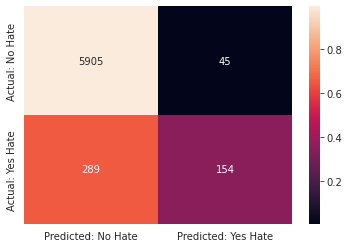

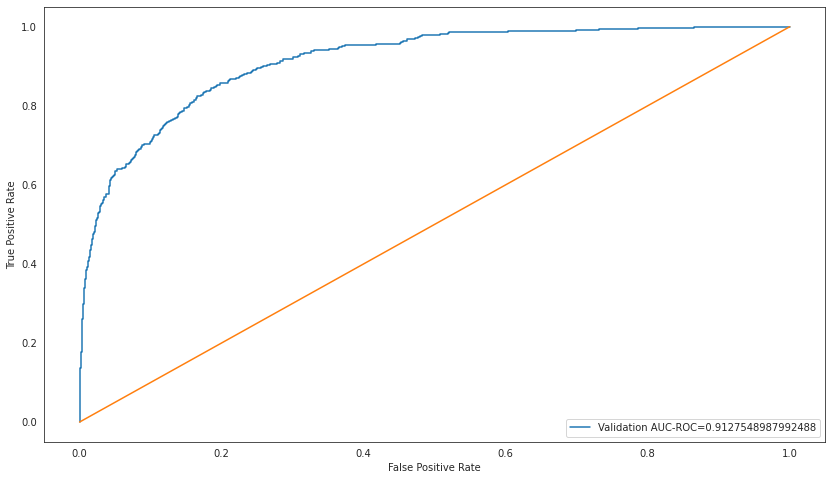

In [17]:
pred, y_pred = train(MultinomialNB(alpha=0.1), MinMaxScaler(), X_train, y_train, X_test)
print(f"ROC AUC Naive Bayes Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

The orange line seen here represents the random selection. What it says is that if i get 50% of the False Positives in my random selection, I also get 50% of the True Positives or True Users that will hate.

## Logistic Regression & Parameter tuning

In [18]:
for c in [0.0001, 0.001, 0.01, 0.1, 1]:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=c), StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{c}->{auc:.4f}")

0.0001->0.9108
0.001->0.9083
0.01->0.9103
0.1->0.9094
1->0.9055


In [19]:
for m in [0.0001, 0.01, 0.1]:
    print(f"Inverse of regularization strength {m}")
    
    for tol in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]:
        pred, y_pred = train(LogisticRegression(solver='liblinear', C=m, tol=tol), StandardScaler(),
                             X_train, y_train, X_test)
        auc = roc_auc_score(y_test, pred)
        print(f"{tol}->{auc:.4f}")
    print()

Inverse of regularization strength 0.0001
1e-05->0.9108
0.0001->0.9108
0.001->0.9108
0.01->0.9108
0.1->0.9108
1->0.9107
10->0.9110

Inverse of regularization strength 0.01
1e-05->0.9103
0.0001->0.9103
0.001->0.9103
0.01->0.9103
0.1->0.9101
1->0.9078
10->0.9004

Inverse of regularization strength 0.1
1e-05->0.9094
0.0001->0.9094
0.001->0.9094
0.01->0.9094
0.1->0.9092
1->0.9082
10->0.9002



In [20]:
for mClass in ["auto", "ovr"]:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=10, multi_class=mClass),
                         StandardScaler(),
                         X_train, y_train, X_test)
    
    auc = roc_auc_score(y_test, pred)
    print(f"{mClass}->{auc:.4f}")

auto->0.9110
ovr->0.9110


ROC AUC Logistic Regression Score: 0.9110


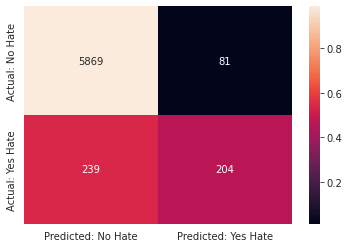

In [21]:
pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=10, multi_class='auto'),
                     StandardScaler(),
                     X_train, y_train, X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

#### Apply Cost-Sensitive Logistic Regression for Imbalanced Classification

ROC AUC Logistic Regression Score: 0.9110


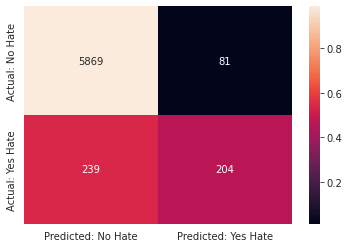

ROC AUC Logistic Regression Score: 0.9116


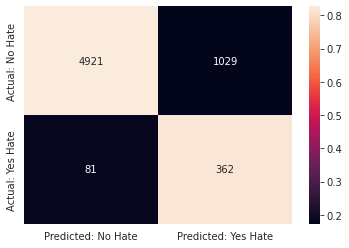

ROC AUC Logistic Regression Score: 0.8926


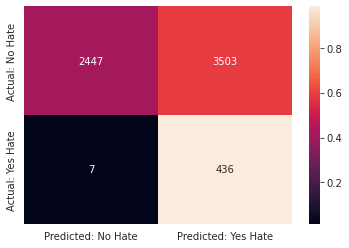

In [22]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=10, multi_class='auto',
                                            class_weight=weight),
                         StandardScaler(),
                         X_train, y_train, X_test)
    print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC Logistic Regression Score: 0.9116


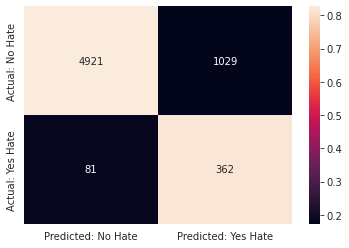

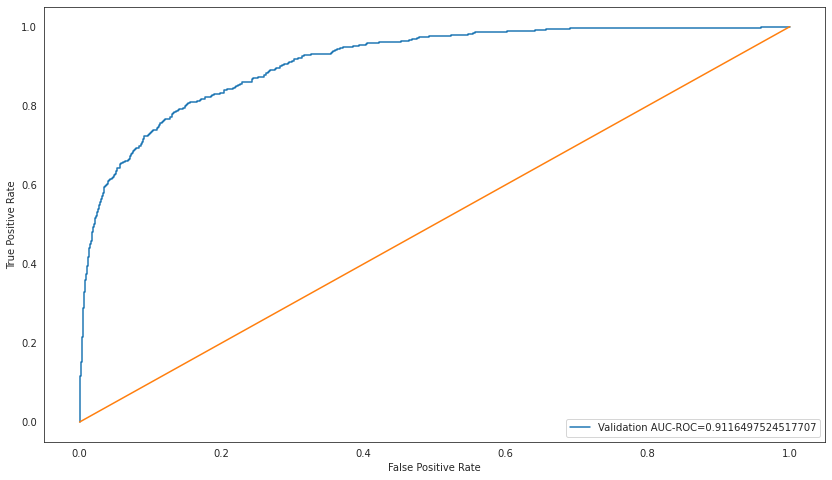

,label,Predicted_class
29830,0,0
21220,0,0
9244,0,0
31397,0,1
6858,0,0
31093,0,0
5549,0,0
24302,0,1
2763,0,0
24455,1,0


In [23]:
pred, y_pred = train(LogisticRegression(solver='liblinear', C=0.0001, tol=10, multi_class='auto',
                                        class_weight={0:1,1:10}),
                     StandardScaler(),
                     X_train, y_train, X_test)
print(f"ROC AUC Logistic Regression Score: {roc_auc_score(y_test, pred):.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

## Random Forest & Parameter tuning

In [24]:
for n in [250, 300, 350]:
    pred, y_pred = train(RandomForestClassifier(n_estimators=n, random_state=42),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

250->0.9065
300->0.9082
350->0.9089


In [25]:
for m in [300, 350]:
    print(f"Number of estimators {m}")
    
    for c in ["gini", "entropy"]:
        pred, y_pred = train(RandomForestClassifier(n_estimators=m, criterion=c, random_state=42),
                             StandardScaler(),
                             X_train, y_train, X_test)
        auc = roc_auc_score(y_test, pred)
        print(f"{c}->{auc:.4f}")
    print()

Number of estimators 300
gini->0.9082
entropy->0.9183

Number of estimators 350
gini->0.9089
entropy->0.9191



In [26]:
for samp in [2, 3, 4]:
    pred, y_pred = train(RandomForestClassifier(n_estimators=350, criterion='entropy', 
                                                max_depth=None, min_samples_split=samp),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{samp}->{auc:.4f}")

2->0.9189
3->0.9170
4->0.9161


ROC AUC Random Forest Classifier Score: 0.9261
'%' of Misclassified class: 4.520569372751447


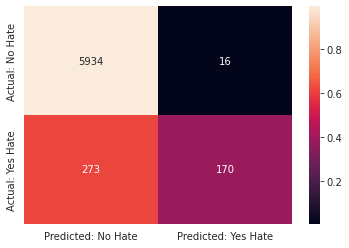

,label,Predicted_class
29830,0,0
21220,0,0
9244,0,0
31397,0,0
6858,0,0
31093,0,0
5549,0,0
24302,0,0
2763,0,0
24455,1,0


In [27]:
pred, y_pred = train(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                            max_depth=None, class_weight={0:1,1:100}, random_state=42),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

ROC AUC Random Forest Classifier Score: 0.9191
'%' of Misclassified class: 4.473643047082747


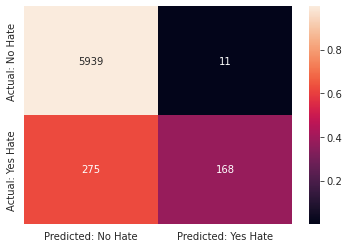

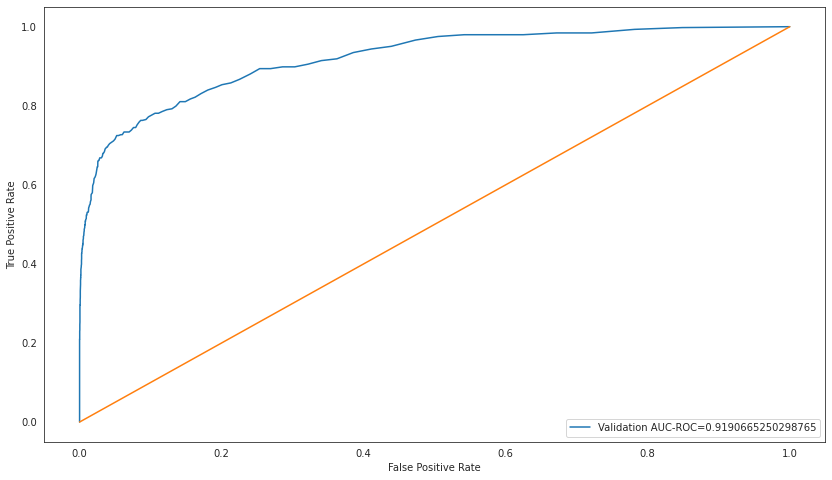

,label,Predicted_class
29830,0,0
21220,0,0
9244,0,0
31397,0,0
6858,0,0
31093,0,0
5549,0,0
24302,0,0
2763,0,0
24455,1,0


In [28]:
pred, y_pred = train(RandomForestClassifier(n_estimators=350, criterion='entropy',
                                            max_depth=None, random_state=42),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC Random Forest Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test[0:30])
out['Predicted_class'] = y_pred[0:30]
out

## LGMClassifier & Parameter tuning

In [29]:
for n in [25, 50, 100, 150, 200, 250, 300, 350, 400]:
    pred, y_pred = train(LGBMClassifier(n_estimators=n, objective='binary'),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

25->0.8984
50->0.9122
100->0.9202
150->0.9226
200->0.9241
250->0.9245
300->0.9243
350->0.9237
400->0.9241


In [30]:
for lr in [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5]:
    pred, y_pred = train(LGBMClassifier(n_estimators=250, objective='binary', learning_rate=lr),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.001->0.8233
0.01->0.8974
0.1->0.9245
1->0.5064
1.5->0.5574
2->0.5303
2.5->0.5039


ROC AUC LGBM Classifier Score: 0.9245


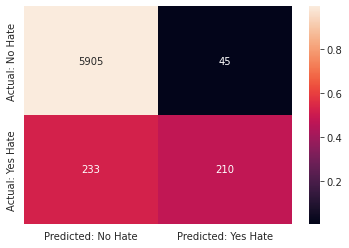

In [31]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, learning_rate=0.1, objective='binary'),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
plt.show()

ROC AUC LGBM Classifier Score: 0.9245


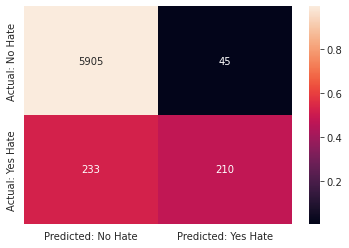

ROC AUC LGBM Classifier Score: 0.9287


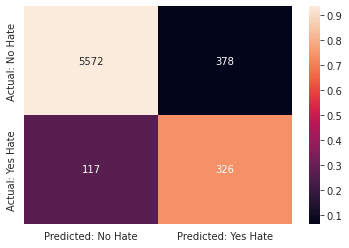

ROC AUC LGBM Classifier Score: 0.9213


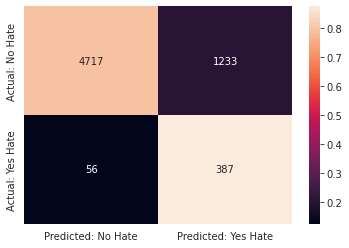

In [32]:
balance = [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]

for weight in balance:
    pred, y_pred = train(LGBMClassifier(n_estimators=250, learning_rate=0.1, objective='binary',
                                        class_weight=weight),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_plot(cm)
    plt.show()

ROC AUC LGBM Classifier Score: 0.9287


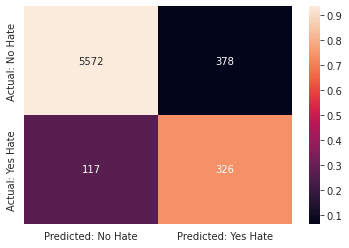

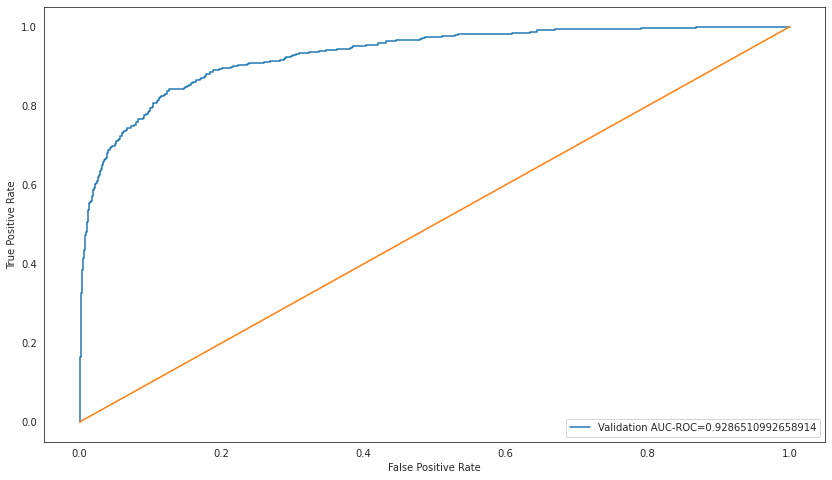

In [33]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, learning_rate=0.1, objective='binary',
                                    class_weight={0:1,1:10}),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC LGBM Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

## XGBoost & Parameter tuning

In [34]:
for n in [200, 300, 350]:
    pred, y_pred = train(XGBClassifier(n_estimators=n, eval_metric="auc", 
                                       objective='binary:logistic'),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{n}->{auc:.4f}")

200->0.9182
300->0.9195
350->0.9208


In [35]:
for lr in [0.0001, 0.001, 0.1, 1]:
    pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                       objective='binary:logistic', learning_rate=lr),
                         StandardScaler(),
                         X_train, y_train, X_test)
    auc = roc_auc_score(y_test, pred)
    print(f"{lr}->{auc:.4f}")

0.0001->0.6431
0.001->0.6771
0.1->0.9146
1->0.8880


ROC AUC XGBoost Classifier Score: 0.9208


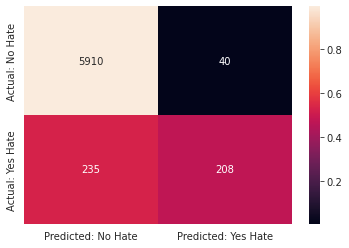

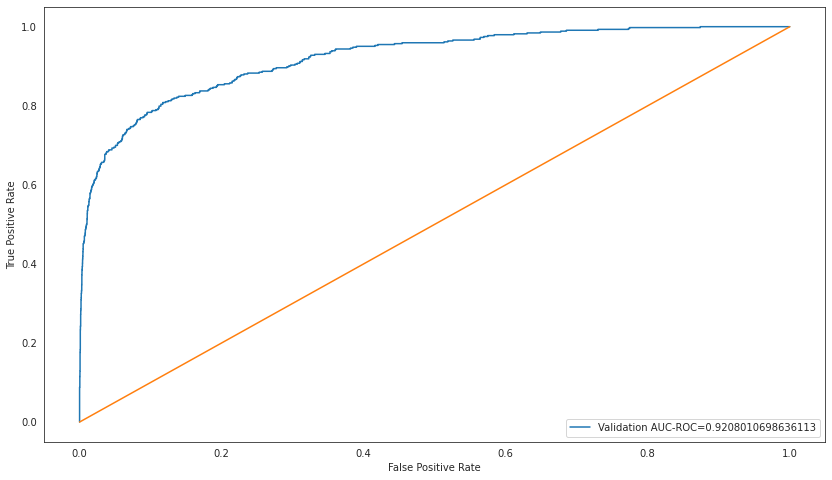

In [36]:
pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train, y_train, X_test)
auc = roc_auc_score(y_test, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

The Random Forest model has the best performance. We will use cross validation to prevent overfitting and check so we know the actual scores of individual model.

# Model Evaluation with Cross Validation

In [17]:
def cross_validation_score(ml_model, scaler, thres = 0.5, random_st=42, cols = data_cleaned.columns):
    
    """
    Function to calculate the k fold cross validation stratified on the basis of target
    and prints the ROC, Recall and Precision Scores.
    
    Args:
        ml_model (numpy array) : ml_model for predictions
        thres (float) : threshold for the probabilities of the model predictions
        random_st (int) : random_st is the random state for Kfold
        cols (string) : cols are the column names
    
    Returns:
        cv_scores (float) : cross validation scores
    """
    
    i= 1
    x1 = data_cleaned.copy()
    x1 = data_cleaned[cols]
    cv_scores = []
    
    sKf = StratifiedKFold(n_splits= 5, shuffle= True, random_state= random_st)
    
    for train_index, test_index in sKf.split(x1, y):
        print(f"\n{i} of KFold {sKf.n_splits}")
        xtrain, xval = x1.iloc[train_index], x1.iloc[test_index]
        ytrain, yval = y.iloc[train_index], y.iloc[test_index]
        
        model = ml_model
        pipeline = make_pipeline(scaler, model)
        pipeline.fit(xtrain, ytrain)
        y_pred = pipeline.predict(xval)
        pred_probs = pipeline.predict_proba(xval)
        pp = []
        
        # Use threshold to define the classes based on probability values
        for j in pred_probs[:,1]:
            if j > thres:
                pp.append(1)
            else:
                pp.append(0)
        # Calculate scores for each fold
        pred_val = pp
        roc_score = roc_auc_score(yval, pred_probs[:,1])
        recall = recall_score(yval, pred_val)
        precision = precision_score(yval, pred_val)
        msg = ""
        msg += f"ROC AUC Score: {roc_score:.4f}, Recall Score: {recall:.4f}, Precision Score: {precision:.4f}"
        print(f"{msg}")
        cv_scores.append(roc_score)
        i+=1
        
    return cv_scores

## Multinomial NB

In [19]:
y=target_labelled_data
nb_cv_score = cross_validation_score(MultinomialNB(alpha=0.1), MinMaxScaler())


1 of KFold 5
ROC AUC Score: 0.9110, Recall Score: 0.3274, Precision Score: 0.7424

2 of KFold 5
ROC AUC Score: 0.9126, Recall Score: 0.3140, Precision Score: 0.7790

3 of KFold 5
ROC AUC Score: 0.9085, Recall Score: 0.3170, Precision Score: 0.7717

4 of KFold 5
ROC AUC Score: 0.9112, Recall Score: 0.3504, Precision Score: 0.7512

5 of KFold 5
ROC AUC Score: 0.9146, Recall Score: 0.3571, Precision Score: 0.7240


## Logistic Regression

In [39]:
log_cv_score = cross_validation_score(LogisticRegression(solver='liblinear', 
                                       C=0.0001, tol=10, multi_class='auto',
                                       class_weight={0:1,1:10}), StandardScaler())


1 of KFold 5
ROC AUC Score: 0.8981, Recall Score: 0.7862, Precision Score: 0.2611

2 of KFold 5
ROC AUC Score: 0.9099, Recall Score: 0.7996, Precision Score: 0.2657

3 of KFold 5
ROC AUC Score: 0.9093, Recall Score: 0.8103, Precision Score: 0.2580

4 of KFold 5
ROC AUC Score: 0.9113, Recall Score: 0.7991, Precision Score: 0.2525

5 of KFold 5
ROC AUC Score: 0.9131, Recall Score: 0.8103, Precision Score: 0.2569


## RandomForestClassifier

In [40]:
rf_cv_score = cross_validation_score(RandomForestClassifier(n_estimators=350,
                                                            criterion='entropy', max_depth=None,
                                                            class_weight={0:1,1:100},
                                                            random_state=42),
                                     StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9247, Recall Score: 0.3786, Precision Score: 0.8995

2 of KFold 5
ROC AUC Score: 0.9252, Recall Score: 0.3608, Precision Score: 0.9050

3 of KFold 5
ROC AUC Score: 0.9171, Recall Score: 0.3839, Precision Score: 0.9101

4 of KFold 5
ROC AUC Score: 0.9273, Recall Score: 0.4129, Precision Score: 0.8894

5 of KFold 5
ROC AUC Score: 0.9138, Recall Score: 0.4174, Precision Score: 0.8905


## LGBMClassifier

In [41]:
lgm_cv_score = cross_validation_score(LGBMClassifier(n_estimators=250, 
                                                     learning_rate=0.1, objective='binary',
                                                     class_weight={0:1,1:10}),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9250, Recall Score: 0.6771, Precision Score: 0.4477

2 of KFold 5
ROC AUC Score: 0.9345, Recall Score: 0.6771, Precision Score: 0.4713

3 of KFold 5
ROC AUC Score: 0.9178, Recall Score: 0.6897, Precision Score: 0.4558

4 of KFold 5
ROC AUC Score: 0.9232, Recall Score: 0.7254, Precision Score: 0.4552

5 of KFold 5
ROC AUC Score: 0.9239, Recall Score: 0.7076, Precision Score: 0.4366


## XGBClassifier

In [42]:
xgb_cv_score = cross_validation_score(XGBClassifier(n_estimators=350, 
                                                    eval_metric="auc",
                                                    objective='binary:logistic'),
                                      StandardScaler())


1 of KFold 5
ROC AUC Score: 0.9217, Recall Score: 0.4410, Precision Score: 0.8216

2 of KFold 5
ROC AUC Score: 0.9305, Recall Score: 0.4187, Precision Score: 0.8282

3 of KFold 5
ROC AUC Score: 0.9140, Recall Score: 0.4375, Precision Score: 0.8099

4 of KFold 5
ROC AUC Score: 0.9193, Recall Score: 0.4710, Precision Score: 0.8023

5 of KFold 5
ROC AUC Score: 0.9203, Recall Score: 0.4665, Precision Score: 0.8038


# Comparison of Model Fold wise

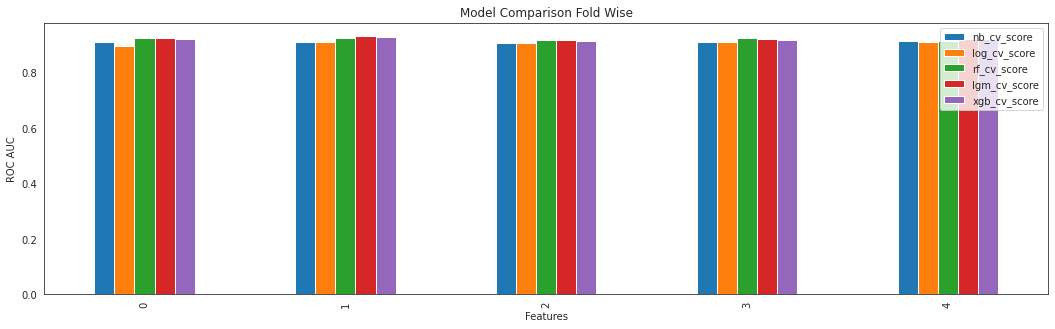

In [43]:
compare_score = pd.DataFrame({'nb_cv_score':nb_cv_score,
                              'log_cv_score':log_cv_score,
                              'rf_cv_score':rf_cv_score,
                              'lgm_cv_score':lgm_cv_score,
                              'xgb_cv_score':xgb_cv_score
                             })

compare_score.plot(y = ['nb_cv_score','log_cv_score','rf_cv_score',
                        'lgm_cv_score','xgb_cv_score'], 
                   kind = 'bar')

plt.title('Model Comparison Fold Wise')
plt.xlabel('Features')
plt.ylabel('ROC AUC');

**The `LGBM Model` & `XGBoost Model` has the best performance across 5-fold. Therefore, we will work on improving them and select the one that generalizes best on unseen data**

In [44]:
xgb_model = XGBClassifier(n_estimators=350, eval_metric="auc", objective='binary:logistic')
xgb_model.fit(X_train.values, y_train)

step_factor = 0.02
threshold_value = 0.1
roc_score = 0
proba = xgb_model.predict_proba(X_test.values)

# Continue to check for optimal value when threshold is
# less than 0.8
while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.1->0.8365187700362312
Threshold: 0.12000000000000001->0.8348365802302863
Threshold: 0.14->0.8263823813949959
Threshold: 0.16->0.8228992545099303
Threshold: 0.18->0.8130527154428364
Threshold: 0.19999999999999998->0.8113111520003035
Threshold: 0.21999999999999997->0.8024614450746439
Threshold: 0.23999999999999996->0.7974063395109736
Threshold: 0.25999999999999995->0.7941521710264242
Threshold: 0.27999999999999997->0.7906459017015384
Threshold: 0.3->0.7851343968738738
Threshold: 0.32->0.7825046948802095
Threshold: 0.34->0.7720583492990877
Threshold: 0.36000000000000004->0.7679638446800843
Threshold: 0.38000000000000006->0.7650820418460837
Threshold: 0.4000000000000001->0.7519581918546199
Threshold: 0.4200000000000001->0.7454382836656108
Threshold: 0.4400000000000001->0.7444776827209438
Threshold: 0.46000000000000013->0.7415118462734982
Threshold: 0.48000000000000015->0.7341994043667128
Threshold: 0.5000000000000001->0.7314016351461579
Threshold: 0.5200000000000001->0.7257582

In [52]:
cross_validation_score(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                       StandardScaler(), thres=0.1)


1 of KFold 5
ROC AUC Score: 0.9305, Recall Score: 0.6192, Precision Score: 0.6465

2 of KFold 5
ROC AUC Score: 0.9353, Recall Score: 0.5969, Precision Score: 0.6634

3 of KFold 5
ROC AUC Score: 0.9207, Recall Score: 0.6116, Precision Score: 0.6402

4 of KFold 5
ROC AUC Score: 0.9310, Recall Score: 0.6138, Precision Score: 0.6366

5 of KFold 5
ROC AUC Score: 0.9304, Recall Score: 0.6540, Precision Score: 0.6328


[0.9304724571127105,
 0.9353372755967351,
 0.9206684261440107,
 0.9309798821741011,
 0.9304154624711595]

In [45]:
lgb_model = LGBMClassifier(n_estimators=250, 
                         learning_rate=0.1, objective='binary',
                         class_weight={0:1,1:10})

lgb_model.fit(X_train.values, y_train)

step_factor = 0.02
threshold_value = 0.1
roc_score = 0
proba = lgb_model.predict_proba(X_test.values)

while threshold_value <= 0.8:
    temp_thresh = threshold_value
    predicted = (proba[:,1] >= temp_thresh).astype('int')
    print(f"Threshold: {temp_thresh}->{roc_auc_score(y_test, predicted)}")
    #store the threshold for best classification
    if roc_score < roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        threshold_score = threshold_value
    threshold_value = threshold_value + step_factor
print(f'\n---Optimum Threshold: {threshold_score}->ROC: {roc_score}')

Threshold: 0.1->0.7992129673539844
Threshold: 0.12000000000000001->0.812417815884819
Threshold: 0.14->0.8172424455109357
Threshold: 0.16->0.8231117096951648
Threshold: 0.18->0.8287173018191476
Threshold: 0.19999999999999998->0.8365802302862453
Threshold: 0.21999999999999997->0.841681620729556
Threshold: 0.23999999999999996->0.8475277424739648
Threshold: 0.25999999999999995->0.8482825274579358
Threshold: 0.27999999999999997->0.8490257412219967
Threshold: 0.3->0.8536953923781702
Threshold: 0.32->0.8537663372346682
Threshold: 0.34->0.8514118785211603
Threshold: 0.36000000000000004->0.8499339871388737
Threshold: 0.38000000000000006->0.8466073562607888
Threshold: 0.4000000000000001->0.8474230324183849
Threshold: 0.4200000000000001->0.8427156325284064
Threshold: 0.4400000000000001->0.8410581026993191
Threshold: 0.46000000000000013->0.8406973082686799
Threshold: 0.48000000000000015->0.8407566819052676
Threshold: 0.5000000000000001->0.8375140846406283
Threshold: 0.5200000000000001->0.835352353

In [20]:
cross_validation_score(LGBMClassifier(n_estimators=250, 
                                      learning_rate=0.1, objective='binary',
                                      class_weight={0:1,1:10}),
                       StandardScaler(), thres=0.32)


1 of KFold 5
ROC AUC Score: 0.9250, Recall Score: 0.7906, Precision Score: 0.3224

2 of KFold 5
ROC AUC Score: 0.9345, Recall Score: 0.8018, Precision Score: 0.3288

3 of KFold 5
ROC AUC Score: 0.9178, Recall Score: 0.7946, Precision Score: 0.3061

4 of KFold 5
ROC AUC Score: 0.9232, Recall Score: 0.8304, Precision Score: 0.3108

5 of KFold 5
ROC AUC Score: 0.9239, Recall Score: 0.8080, Precision Score: 0.3086


[0.9250266780972822,
 0.9344977773248163,
 0.9177881206739089,
 0.9231506711449722,
 0.9238912138290714]

There is no improvement in the recall score

**Ways to improve this model**
1. Add more training data
2. Try Over/Undersampling techniques like SMOTE

# Addressing Imbalanced Class with SMOTE

In [16]:
print(data_cleaned.shape)
print(target_labelled_data.shape)

(31962, 1018)
(31962,)


In [17]:
print(target_labelled_data.value_counts())
print(target_labelled_data.value_counts(normalize=True)*100)

0    29720
1     2242
Name: label, dtype: int64
0    92.98542
1     7.01458
Name: label, dtype: float64


In [18]:
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(data_cleaned, target_labelled_data)
print(y_sm.value_counts())
print(y_sm.value_counts(normalize=True)*100)

0    29720
1    29720
Name: label, dtype: int64
0    50.0
1    50.0
Name: label, dtype: float64


In [19]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, stratify=y_sm, 
                                                                random_state= 42, test_size= 0.2)

ROC AUC XGBoost Classifier Score: 0.9965
'%' of Misclassified class: 2.2459623149394345


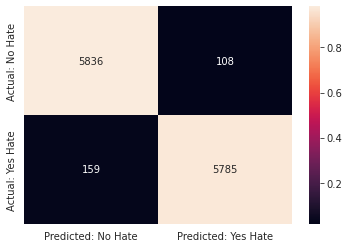

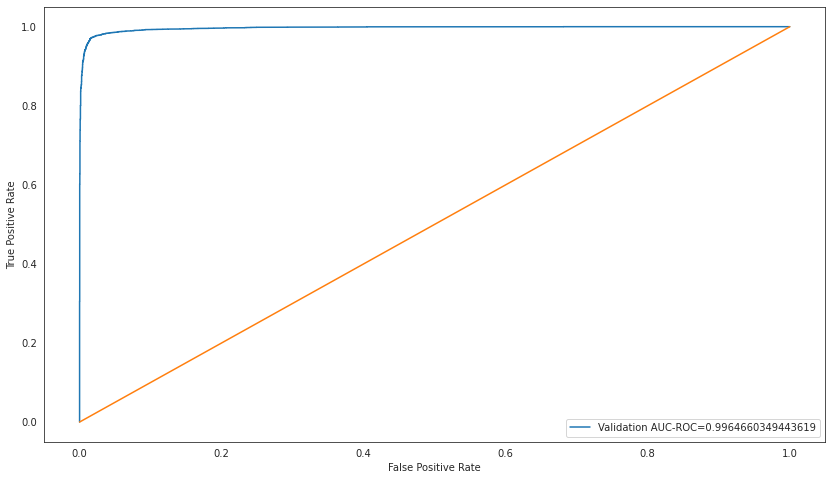

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [20]:
pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test_sm)

auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

ROC AUC LGBMClassifier Score: 0.9956
'%' of Misclassified class: 6.864064602960969


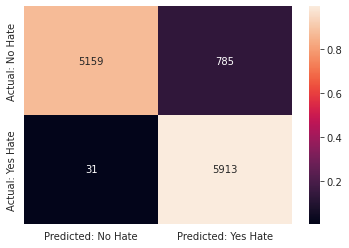

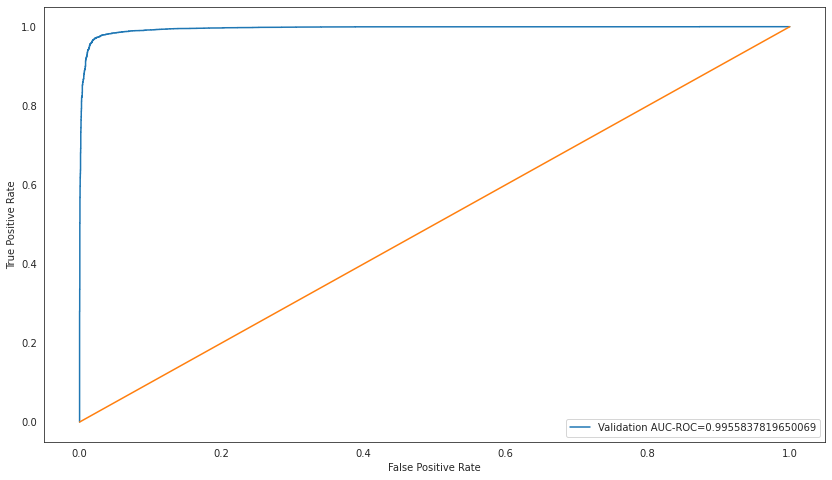

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,1
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [21]:
pred, y_pred = train(LGBMClassifier(n_estimators=250, 
                                    learning_rate=0.1, objective='binary',
                                    class_weight={0:1,1:10}),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test_sm)

auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC LGBMClassifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

**We will use the XGBoost Classifier because of it's low '%' of Misclassified labels**

ROC AUC XGBoost Classifier Score: 0.9965
'%' of Misclassified class: 2.2459623149394345


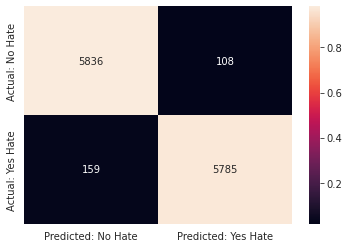

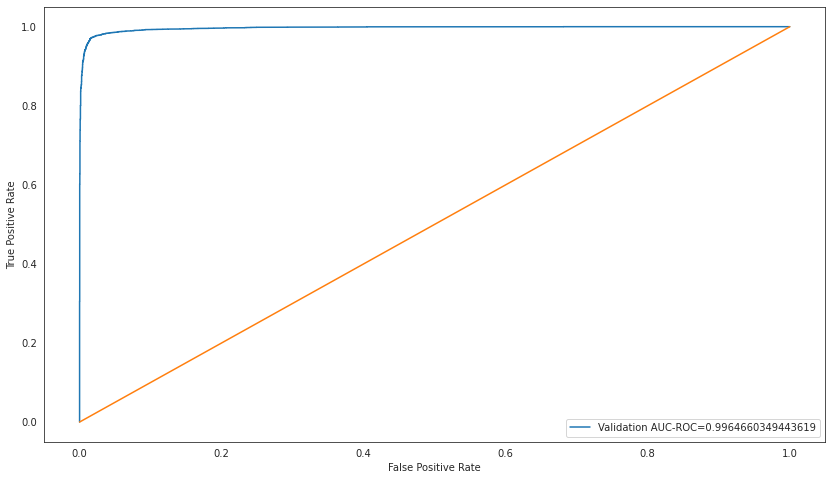

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,1
44698,1,1
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [23]:
xgb_pipeline = make_pipeline(StandardScaler(),
                             XGBClassifier(n_estimators=350, eval_metric="auc", 
                                           objective='binary:logistic'))

xgb_pipeline.fit(X_train_sm.values, y_train_sm)
pred = xgb_pipeline.predict_proba(X_test_sm.values)[:, 1]
y_pred = xgb_pipeline.predict(X_test_sm.values)
auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

# Semi-Supervised using label propagation approach

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initiate iteration counter
iterations = 0

# Containers to hold f1_scores and # of pseudo-labels
train_f1s = []
test_f1s = []
pseudo_labels = []

# Assign value to initiate while loop
high_prob = [1] 

# Loop will run until there are no more high-probability pseudo-labels
while len(high_prob) > 0:
    
    # Set the vector transformer (from data train)
    columnTransformer = ColumnTransformer([
    ('tfidf',TfidfVectorizer(stop_words=None, max_features=100000),
     'Content')
    ],remainder='drop')

    def transforms(series):
        before_vect = pd.DataFrame({'Content':series})
        vector_transformer = columnTransformer.fit(pd.DataFrame({'Content':X_train}))
        return vector_transformer.transform(before_vect)

    X_train_df = transforms(X_train);
    X_test_df = transforms(X_test);
    X_unlabeled_df = transforms(X_unlabeled)
    
    # Fit classifier and make train/test predictions
    nb = MultinomialNB()
    nb.fit(X_train_df, y_train)
    y_hat_train = nb.predict(X_train_df)
    y_hat_test = nb.predict(X_test_df)

    # Calculate and print iteration # and f1 scores, and store f1 scores
    train_f1 = f1_score(y_train, y_hat_train)
    test_f1 = f1_score(y_test, y_hat_test)
    print(f"Iteration {iterations}")
    print(f"Train f1: {train_f1}")
    print(f"Test f1: {test_f1}")
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)
   
    # Generate predictions and probabilities for unlabeled data
    print(f"Now predicting labels for unlabeled data...")

    pred_probs = nb.predict_proba(X_unlabeled_df)
    preds = nb.predict(X_unlabeled_df)
    prob_0 = pred_probs[:,0]
    prob_1 = pred_probs[:,1]

    # Store predictions and probabilities in dataframe
    df_pred_prob = pd.DataFrame([])
    df_pred_prob['preds'] = preds
    df_pred_prob['prob_0'] = prob_0
    df_pred_prob['prob_1'] = prob_1
    df_pred_prob.index = X_unlabeled.index
    
    # Separate predictions with > 99% probability
    high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > 0.99],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > 0.99]],
                          axis=0)
    
    print(f"{len(high_prob)} high-probability predictions added to training data.")
    
    pseudo_labels.append(len(high_prob))

    # Add pseudo-labeled data to training data
    X_train = pd.concat([X_train, X_unlabeled.loc[high_prob.index]], axis=0)
    y_train = pd.concat([y_train, high_prob.preds])      
    
    # Drop pseudo-labeled instances from unlabeled data
    X_unlabeled = X_unlabeled.drop(index=high_prob.index)
    
    print(f"{len(X_unlabeled)} unlabeled instances remaining.\n")
    
    # Update iteration counter
    iterations += 1

# Pseudo-Labelling based on Confidence

In [ ]:
augmented_test = test.copy(deep=True)
    augmented_test[target] = pseudo_labeles

In [30]:
print("Predicting labels for unlabelled data"+".."*2)
preds_probs = xgb_pipeline.predict_proba(unlabelled_cleaned.values)
preds = xgb_pipeline.predict(unlabelled_cleaned.values)

prob_0 = preds_probs[:,0]
prob_1 = preds_probs[:,1]
# Store the predictions and probabilities in a dataframe
pseudo_df = pd.DataFrame([])
pseudo_df['pseudo_labels'] = preds
pseudo_df['prob_0'] = prob_0
pseudo_df['prob_1'] = prob_1
pseudo_df.index = unlabelled_cleaned.index
pseudo_df['max'] = pseudo_df[['prob_0','prob_1']].max(axis=1)

pseudo_df.head()

Predicting labels for unlabelled data....


,pseudo_prediction,prob_0,prob_1,max
0,0,0.992012,0.007988,0.992012
1,0,0.979807,0.020193,0.979807
2,0,0.989798,0.010202,0.989798
3,0,0.987982,0.012018,0.987982
4,0,0.956016,0.043984,0.956016


## Plotting the Confidence

The below graph gives the distribution of confidence as expressed by the probability of the class which is most probable.

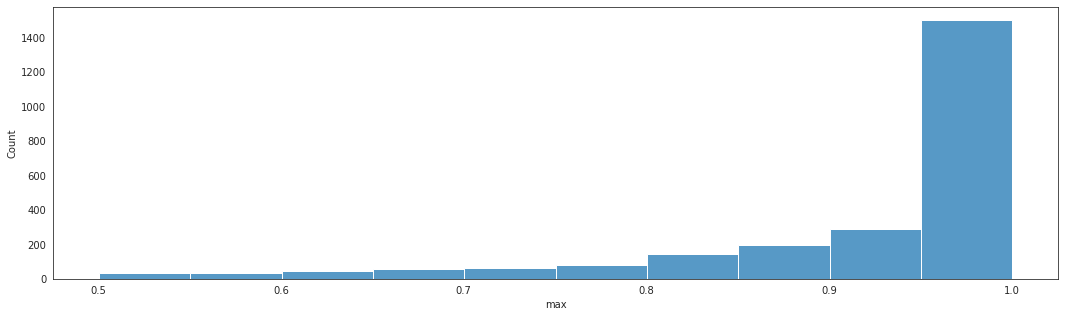

In [31]:
sns.histplot(data = pseudo_df, x = 'max', bins=10)
plt.show()

We will consider probability of 0.8 because of has high probability count which means the predicted labels is near accurate.

In [32]:
conf_ind=pseudo_df["max"]>0.8
X_new = np.append(X_train, unlabelled_cleaned.loc[conf_ind,:], axis=0)
y_new = np.append(y_train, pseudo_df.loc[conf_ind, ['pseudo_prediction']])
X_new = pd.DataFrame(X_new, columns = X_train.columns)
y_new = pd.Series(y_new, name = 'label')

print(f"Old Train Data shape: {X_train.shape} \nOld Train label shape: {y_train.shape}\n \nNew Train Data shape: {X_new.shape} \nNew Train label shape: {y_new.shape}\n")

print(X_new.isnull().sum())
print(y_new.isnull().sum())

Old Train Data shape: (25569, 1018) 
Old Train label shape: (25569,)
 
New Train Data shape: (27700, 1018) 
New Train label shape: (27700,)

absolutely            0
accept                0
accounot              0
act                   0
action                0
                     ..
avg_sent_len          0
uniq_vs_words         0
stopwords_vs_words    0
title_word_count      0
uppercase_count       0
Length: 1018, dtype: int64
0


Performance after Semi-Supervised Learning
ROC AUC XGBoost Classifier Score: 0.9208
'%' of Misclassified class: 4.317221961520413


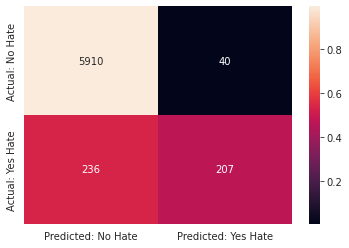

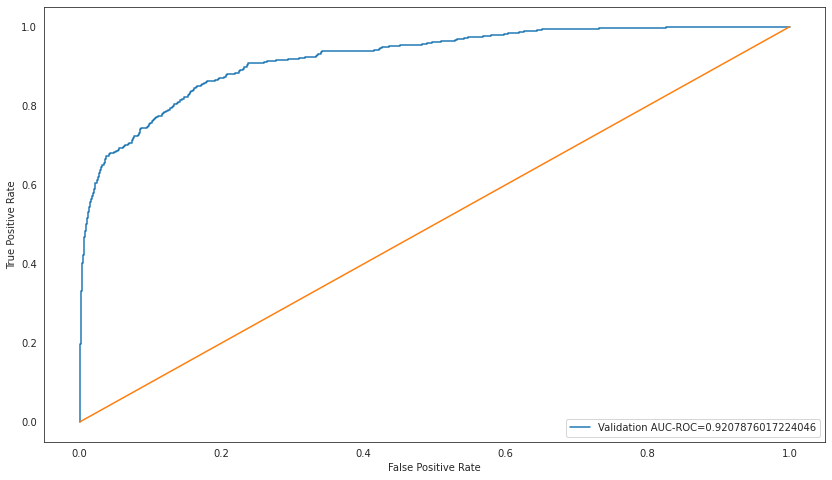

,label,Predicted_class
19659,0,0
16292,0,0
19888,0,0
57178,1,0
44698,1,0
8215,0,0
16936,0,0
28916,0,0
25288,0,0
29736,0,0


In [35]:
xgb_pipeline = make_pipeline(StandardScaler(),
                             XGBClassifier(n_estimators=350, eval_metric="auc", 
                                           objective='binary:logistic'))

xgb_pipeline.fit(X_new.values, y_new)
pred = xgb_pipeline.predict_proba(X_test.values)[:, 1]
y_pred = xgb_pipeline.predict(X_test.values)
auc = roc_auc_score(y_test, pred)
print('Performance after Semi-Supervised Learning')
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test)*100)
cm = confusion_matrix(y_test, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test, pred)
plt.show()

# compare the actual class and predicted class
out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

# Apply SMOTE

In [36]:
print(X_new.shape)
print(y_new.shape)

(27700, 1018)
(27700,)


In [37]:
print(y_new.value_counts())
print(y_new.value_counts(normalize=True)*100)

smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(X_new, y_new)
print()
print('After applying SMOTE')
print(y_sm.value_counts())
print(y_sm.value_counts(normalize=True)*100)

0    25850
1     1850
Name: label, dtype: int64
0    93.3213
1     6.6787
Name: label, dtype: float64

After applying SMOTE
1    25850
0    25850
Name: label, dtype: int64
1    50.0
0    50.0
Name: label, dtype: float64


ROC AUC XGBoost Classifier Score: 0.9963
'%' of Misclassified class: 2.2243713733075436


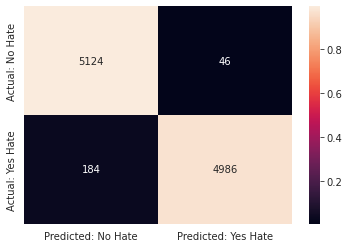

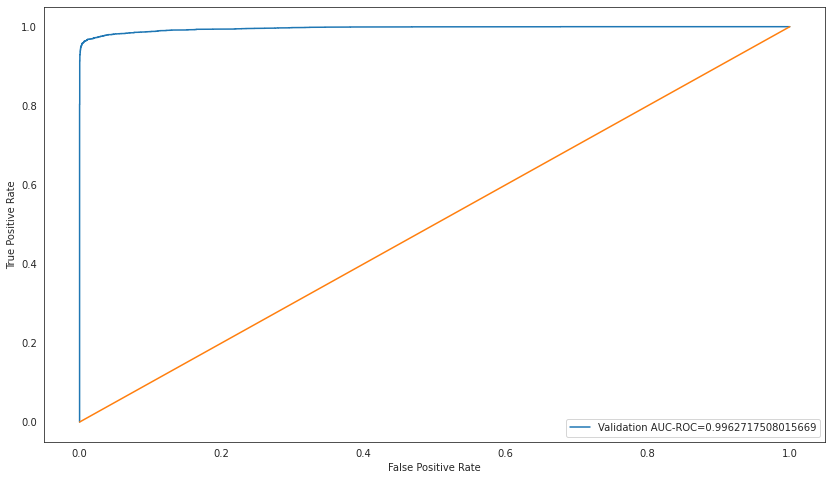

,label,Predicted_class
6525,0,0
36332,1,1
11602,0,0
38774,1,1
40260,1,1
4779,0,0
1812,0,0
27275,0,0
11055,0,0
6221,0,0


In [38]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(x_sm, y_sm, stratify=y_sm, 
                                                                random_state= 42, test_size= 0.2)

pred, y_pred = train(XGBClassifier(n_estimators=350, eval_metric="auc", 
                                    objective='binary:logistic'),
                     StandardScaler(),
                     X_train_sm, y_train_sm, X_test_sm)

auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

out = pd.DataFrame(y_test_sm[0:30])
out['Predicted_class'] = y_pred[0:30]
out

We can see a little improvement in the ROC AUC score and also a reduction in the percentage of Misclassified class. Therefore, we will store this as our final model.

ROC AUC XGBoost Classifier Score: 0.9963
'%' of Misclassified class: 2.2243713733075436


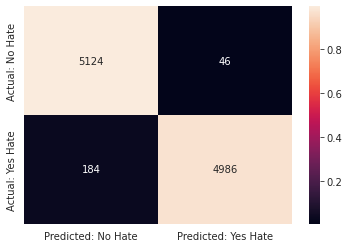

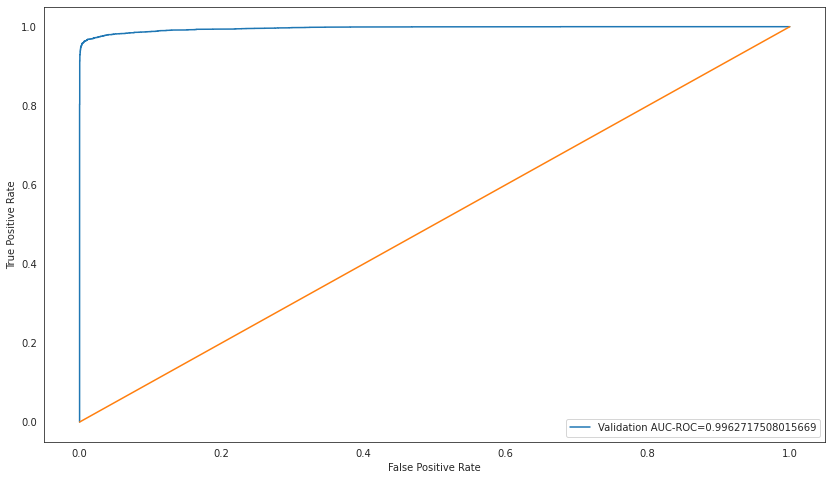

In [39]:
final_model = make_pipeline(StandardScaler(),
                            XGBClassifier(n_estimators=350, eval_metric="auc", 
                                           objective='binary:logistic'))

final_model.fit(X_train_sm.values, y_train_sm)
pred = final_model.predict_proba(X_test_sm.values)[:, 1]
y_pred = final_model.predict(X_test_sm.values)
auc = roc_auc_score(y_test_sm, pred)
print(f"ROC AUC XGBoost Classifier Score: {auc:.4f}")
print("'%' of Misclassified class:", np.mean(y_pred != y_test_sm)*100)
cm = confusion_matrix(y_test_sm, y_pred)
confusion_matrix_plot(cm)
roc_auc_curve(y_test_sm, pred)
plt.show()

# Serialize Tfidf Vectorizer & the Final Model pipeline

In [40]:
with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/vectorizers/vectorizerV3.bin', 'wb') as f:
    joblib.dump(tfVectorized, f)
    
with open('/home/daniel/Desktop/programming/pythondatascience/datascience/NLP/sentiment-hate-system/src/models/modelV3.bin', 'wb') as f:
    joblib.dump(final_model, f)